In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gs
import numpy as np

### general functions

In [2]:
def ROI(img):
    """returns the region of interest mask for an image"""
    h = img.shape[0]
    #here are the points set for the polygon, since there are 4 points this is a 4 sided poly
    trapezoid = np.array([[(200,h), (1100,h), (750, 300), (500, 300)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, trapezoid, (255, 255,255))
    return mask

def RGBImage(img):
    """
    used for displaying images in matplotlib that are read with cv2. cv2 colorspace is bgr and normal is rgb.
    this works fine on my desktop but doesnt work on my laptop (due to version issues of course)
    """
    try:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        return img
    
def Canny(img):
    """
    Converts an image to gray scale, applies a gaussian blur (to reduce image noise),
    then dilates the image to increase the line size / weight, and finally returns the canny.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    can = cv2.Canny(blur, 40, 120)
    ero = cv2.dilate(can, (11,11), iterations=5)
    return ero

def maskLines(img, lines):
    """
    returns a mask of the same size as <@param img>, with the <@param lines> found
    TODO: add the hough transform code here, not in the main
    """
    lineImg = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(lineImg, (x1, y1), (x2, y2), (0,255,0), 10)
    return lineImg

def avgMB(img, lines):
    """
    smoothes the different <@param lines> using np.polyfit
    """
    leftFit = []
    rightFit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        m,b = np.polyfit((x1,x2), (y1,y2), 1)
        if(m < 0):
            leftFit.append((m, b))
        else:
            rightFit.append((m,b))
    
    avgLeftMB = np.average(leftFit, axis=0)
    avgRightMB = np.average(rightFit, axis=0)
    leftLine = unpackLine(img, avgLeftMB)
    rightLine = unpackLine(img, avgRightMB)
    return np.array([leftLine, rightLine])

def unpackLine(img, lineParams):
    """
    returns x1,y1,x2,y2 for a line
    """
    m,b = lineParams
    #the start of the lines is the bottom of the image (i.e. its height)
    y1 = img.shape[0]
    #the end of the lines will be 1/2 the way up the image, play with this value!
    y2 = int(y1*.5)
    x1 = int((y1 - b) / m)
    x2 = int((y2 - b) / m)
    return np.array([x1,y1,x2,y2])
        

### read image and preprocess
- Canny function handles gray and blurr, but they are called for visualization below

In [3]:
img = cv2.imread("test_image.jpg")
rgbImg = RGBImage(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
cny = Canny(img)

mask1 = ROI(img)
maskedImg = cv2.bitwise_and(rgbImg, mask1)

mask2 = ROI(cny)
maskedCny = cv2.bitwise_and(cny, mask2)

### visualize the image
- normal, gray, blurred
- canny original, mask, masked original
- masked canny

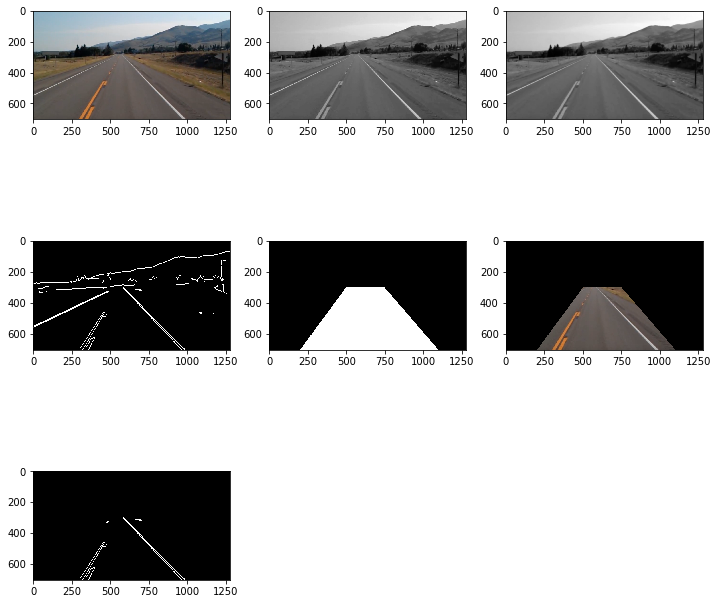

In [4]:
fig = plt.figure(figsize=(12,12))
gs1 = gs.GridSpec(3,3)
gs1.update(hspace=0.0)
cols = 3
rows = 3
fig.add_subplot(rows, cols, 1)
plt.imshow(rgbImg)
fig.add_subplot(rows, cols, 2)
plt.imshow(gray, cmap='gray')
fig.add_subplot(rows, cols, 3)
plt.imshow(blur, cmap='gray')
fig.add_subplot(rows, cols, 4)
plt.imshow(cny, cmap='gray')
fig.add_subplot(rows, cols, 5)
plt.imshow(mask1)
fig.add_subplot(rows, cols, 6)
plt.imshow(maskedImg)
fig.add_subplot(rows, cols, 7)
plt.imshow(maskedCny, cmap='gray')

### Enlarge our frame of interest (masked canny)

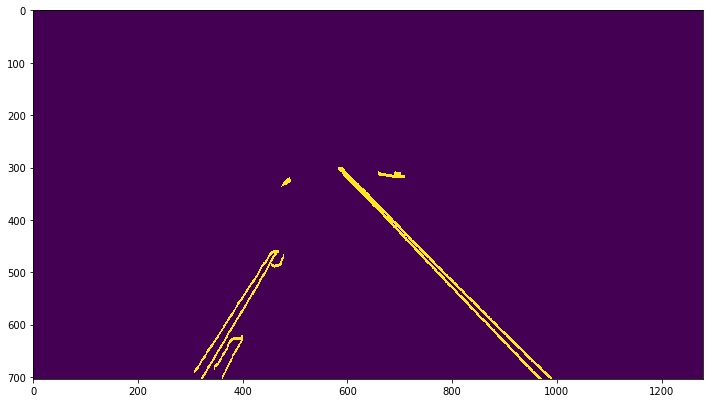

In [5]:
origSize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [origSize[0]*2, origSize[1]*2]
plt.imshow(maskedCny)
plt.rcParams["figure.figsize"] = origSize

### Calculate Hough Lines
- https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

### args: 
- image 
- rho (pixels per bin) 
- theta (angular resolution)
- threshold (number of votes to be a line) 
- placeholder
- min pixels per line
- max gap in pixels for continuous line

In [6]:
lines = cv2.HoughLinesP(maskedCny, 9, np.pi/180, 100, np.array([]), minLineLength=100, maxLineGap=15 )

In [7]:
lines.shape #see how m any lines are detected

(21, 1, 4)

In [8]:
lineBlack = maskLines(rgbImg, lines)

### display the found lines

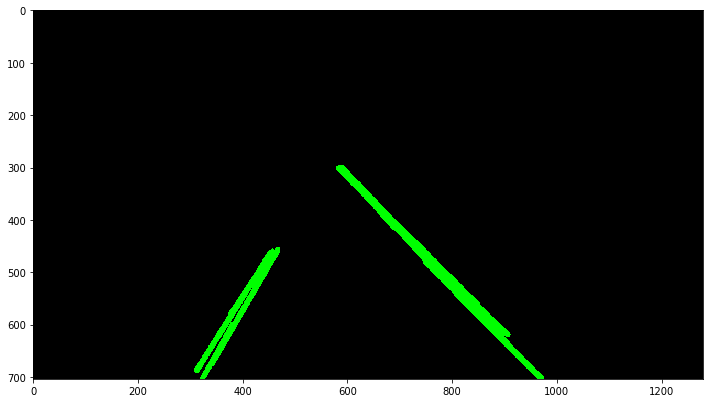

In [9]:
origSize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [origSize[0]*2, origSize[1]*2]
plt.imshow(lineBlack)
plt.rcParams["figure.figsize"] = origSize

### overlay the lines on the original image
- https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=addweighted#addweighted

In [10]:
preFinalImg = cv2.addWeighted(rgbImg, 1.0, lineBlack, .8, 1)

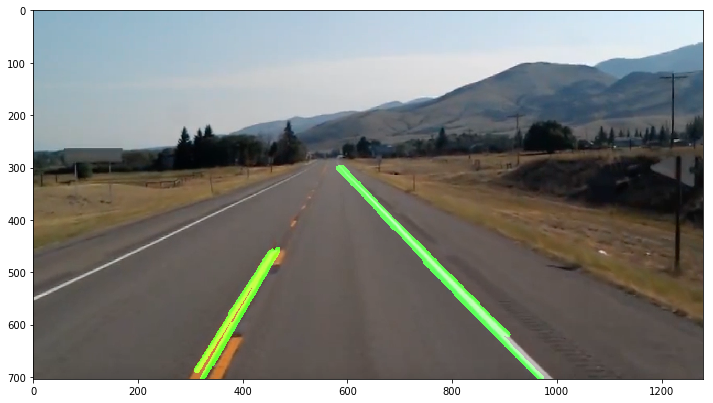

In [11]:
origSize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [origSize[0]*2, origSize[1]*2]
plt.imshow(preFinalImg)
plt.rcParams["figure.figsize"] = origSize

### view the average slope and intercept of the two lines

In [15]:
avgLines = avgMB(rgbImg, lines)
avgLines

array([[307, 704, 525, 352],
       [977, 704, 631, 352]])

In [16]:
lineBlackAvg = maskLines(rgbImg, avgLines)

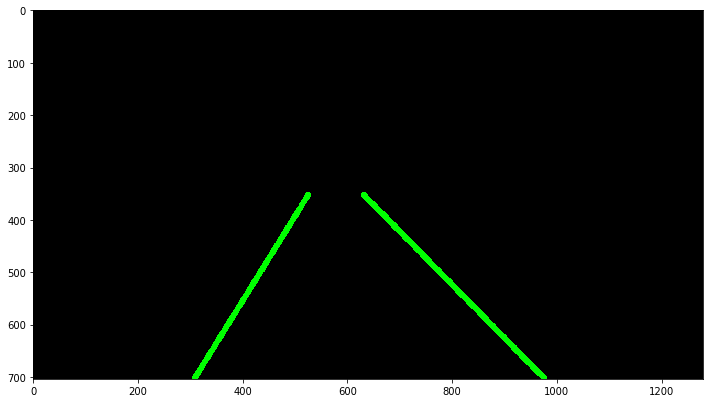

In [17]:
origSize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [origSize[0]*2, origSize[1]*2]
plt.imshow(lineBlackAvg)
plt.rcParams["figure.figsize"] = origSize

In [18]:
finalImg = cv2.addWeighted(rgbImg, 1.0, lineBlackAvg, .8, 1)

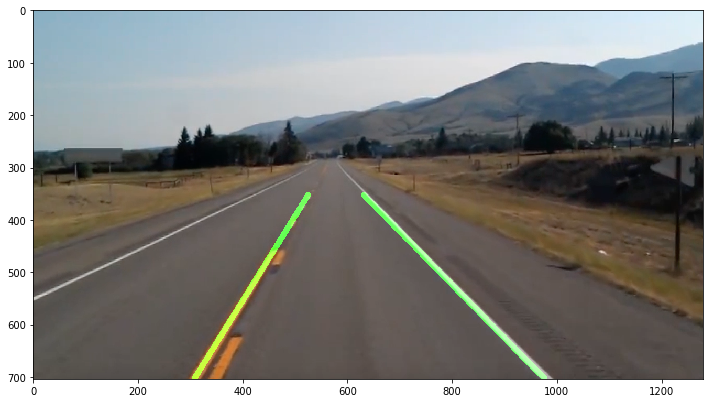

In [19]:
origSize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [origSize[0]*2, origSize[1]*2]
plt.imshow(finalImg)
plt.rcParams["figure.figsize"] = origSize

### Now lets identify lines in a video

In [21]:
cap = cv2.VideoCapture("test2.mp4")
print(cap)
while(cap.isOpened()):
    ret, frame = cap.read()
    cny = Canny(frame)
    msk = ROI(cny)
    mskCny = cv2.bitwise_and(cny, msk)
    lines = cv2.HoughLinesP(mskCny, 9, np.pi/180, 100, np.array([]), minLineLength=100, maxLineGap=15)
    try:
        avgLines = avgMB(frame, lines)
        maskLinesAvg = maskLines(frame, avgLines)
        result = cv2.addWeighted(frame, 1.0, maskLinesAvg, .8, 1)
        cv2.imshow('res', result)
    except Exception as e: #i.e. when there is nothing else in the stream to read
        break
    if(cv2.waitKey(1) == ord('q')):
       break
cap.release()
cv2.destroyAllWindows()

<VideoCapture 0x7fdc453b3bf0>
